In [1]:
import geopandas as gpd
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from bikescience import sp_grid

base_folder = '../../../data/sao-paulo/'

Tracts

In [2]:
tracts = gpd.read_file(base_folder + 'ibge/sectors/33SEE250GC_SIR.shp')
tracts.head()

ID       CD_GEOCODI    TIPO   CD_GEOCODS NM_SUBDIST CD_GEOCODD  \
0  98237.0  354100005000009  URBANO  35410000500       None  354100005   
1  98232.0  354100005000004  URBANO  35410000500       None  354100005   
2  98230.0  354100005000002  URBANO  35410000500       None  354100005   
3  98229.0  354100005000001  URBANO  35410000500       None  354100005   
4  98231.0  354100005000003  URBANO  35410000500       None  354100005   

     NM_DISTRIT CD_GEOCODM    NM_MUNICIP NM_MICRO                     NM_MESO  \
0  PRAIA GRANDE    3541000  PRAIA GRANDE   SANTOS  METROPOLITANA DE SÃO PAULO   
1  PRAIA GRANDE    3541000  PRAIA GRANDE   SANTOS  METROPOLITANA DE SÃO PAULO   
2  PRAIA GRANDE    3541000  PRAIA GRANDE   SANTOS  METROPOLITANA DE SÃO PAULO   
3  PRAIA GRANDE    3541000  PRAIA GRANDE   SANTOS  METROPOLITANA DE SÃO PAULO   
4  PRAIA GRANDE    3541000  PRAIA GRANDE   SANTOS  METROPOLITANA DE SÃO PAULO   

     CD_GEOCODB  NM_BAIRRO  ID1  \
0  354100005001  Boqueirão    1   
1  354100005001  Boqueirão    2   
2  354100005001  Boqueirão    3   
3  354100005001  Boqueirão    4   
4  354100005001  Boqueirão    5   

                                            geometry  
0  POLYGON ((-46.410239 -24.011028, -46.411694999...  
1  POLYGON ((-46.416055 -24.002446, -46.415983999...  
2  POLYGON ((-46.412132 -24.007921, -46.412442 -2...  
3  POLYGON ((-46.411342 -24.00552, -46.411965 -24...  
4  POLYGON ((-46.413264 -24.005136, -46.414838 -2...

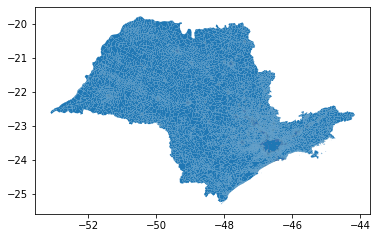

In [3]:
tracts.plot()
plt.show()

Only São Paulo city

In [4]:
tracts.NM_MUNICIP.value_counts().head(10)

SÃO PAULO                18953
CAMPINAS                  1749
GUARULHOS                 1748
SÃO BERNARDO DO CAMPO     1222
SANTO ANDRÉ               1194
SÃO JOSÉ DOS CAMPOS       1074
RIBEIRÃO PRETO            1004
OSASCO                     943
PIRACICABA                 718
JUNDIAÍ                    684
Name: NM_MUNICIP, dtype: int64

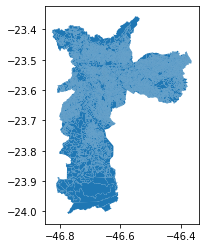

In [5]:
sp_tracts = tracts[tracts.NM_MUNICIP == 'SÃO PAULO']
sp_tracts.plot()
plt.show()

Selected census features

In [6]:
census_features = pd.read_csv(base_folder + 'training-sets/ibge/ibge-census.csv')
census_features.head()

Cod_setor  V001_basic  V002_basic  V003_basic  V004_basic  \
0  355030801000001       266.0       800.0        3.01        2.32   
1  355030801000002       306.0       913.0        2.98        2.09   
2  355030801000003       189.0       625.0        3.31        3.08   
3  355030801000004       181.0       572.0        3.16        2.26   
4  355030801000005       240.0       754.0        3.14        2.35   

   V005_basic  V006_basic  V007_basic  V008_basic  V009_basic  ...  \
0     2091.32  8532451.78     2164.55  8673276.78     1227.41  ...   
1     1650.09  3983441.31     1717.44  4030519.99     1045.78  ...   
2     1280.43  5474593.06     2349.53  7553913.02      902.97  ...   
3     1119.59  3572955.10     1859.13  4567289.50      869.09  ...   
4     1416.90  2240207.58     1581.66  2240109.39      917.71  ...   

   V045_people_inc  V046_people_inc  V047_people_inc  V048_people_inc  \
0              2.0             66.0             95.0             45.0   
1              4.0             97.0            104.0             35.0   
2              1.0             20.0             54.0             20.0   
3              2.0             18.0             60.0             21.0   
4              2.0             68.0             86.0             27.0   

   V049_people_inc  V050_people_inc  V051_people_inc  V052_people_inc  \
0             29.0             26.0              2.0              0.0   
1             23.0             25.0              0.0              2.0   
2             29.0              9.0              1.0              2.0   
3             14.0             12.0              1.0              0.0   
4             23.0             12.0              2.0              0.0   

   V053_people_inc  V054_people_inc  
0              2.0            132.0  
1              2.0            154.0  
2              0.0            160.0  
3              0.0            137.0  
4              0.0            138.0  

[5 rows x 137 columns]

In [7]:
socio_columns = census_features.columns.tolist()
socio_columns.remove('Cod_setor')
for c in socio_columns:
    if not census_features[c].dtype in [np.dtype('float'), np.dtype('int')]:
        print()
        print(c, census_features[c].dtype)
        display(census_features[c].describe())

Intersecting grid cells and census tracts
* Taking indicators proportionally to the intersected area

In [10]:
tracts.CD_GEOCODI = tracts.CD_GEOCODI.astype(int)
census_merge = gpd.GeoDataFrame(tracts.merge(census_features, left_on='CD_GEOCODI', right_on='Cod_setor'))

grid = sp_grid.create(n=13)
proportional = gpd.sjoin(grid.geodataframe(), census_merge, op='intersects') \
               .merge(census_merge[['CD_GEOCODI', 'geometry']], on='CD_GEOCODI')
proportional.rename(columns={'geometry_x': 'geometry_cell', 'geometry_y': 'geometry_tract'}, inplace=True)

proportional['geometry_intersection'] = proportional.apply(
        lambda row: row.geometry_cell.intersection(row.geometry_tract),
        axis=1)
proportional['proportion'] = \
        gpd.GeoSeries(proportional.geometry_intersection).area / gpd.GeoSeries(proportional.geometry_tract).area

proportional.proportion.head()

0    0.712958
1    0.206274
2    1.000000
3    1.000000
4    0.563888
Name: proportion, dtype: float64

In [11]:
proportional.proportion.describe()

count    2.049800e+04
mean     8.896484e-01
std      2.644111e-01
min      1.234763e-08
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: proportion, dtype: float64

In [12]:
aggs = {}
for c in socio_columns:
    proportional[c] = proportional['proportion'] * proportional[c]
    aggs[c] = ['min', 'max', 'mean', 'std']
    
per_cell = proportional.groupby(['i', 'j'], as_index=False).agg(aggs)
per_cell.columns = ['_'.join(col).strip() for col in per_cell.columns.values]
per_cell.rename(columns={'i_': 'i', 'j_': 'j'}, inplace=True)
per_cell.head()

i  j  V001_basic_min  V001_basic_max  V001_basic_mean  V001_basic_std  \
0  0  3        6.798823      142.473493        45.283896       40.819449   
1  0  4        0.592035      587.000000       116.387066      114.489342   
2  0  5        0.001238      314.000000        43.791846       75.284214   
3  0  6        0.070644       76.516796        10.825073       17.661879   
4  1  3        0.080197      210.000000        31.345918       52.852837   

   V002_basic_min  V002_basic_max  V002_basic_mean  V002_basic_std  ...  \
0       15.000000      587.249102       169.028947      166.886061  ...   
1        0.592035     2098.000000       412.702317      406.007489  ...   
2        0.004210     1147.000000       157.095334      272.310070  ...   
3        0.176611      254.278379        37.156017       60.548842  ...   
4        0.318202      631.000000       108.175813      159.617304  ...   

   V052_people_inc_mean  V052_people_inc_std  V053_people_inc_min  \
0              0.000000             0.000000                  0.0   
1              0.016983             0.118133                  0.0   
2              0.000000             0.000000                  0.0   
3              0.000000             0.000000                  0.0   
4              0.000000             0.000000                  0.0   

   V053_people_inc_max  V053_people_inc_mean  V053_people_inc_std  \
0                  1.0              0.100000             0.316228   
1                  1.0              0.023529             0.152477   
2                  1.0              0.013699             0.117041   
3                  0.0              0.000000             0.000000   
4                  0.0              0.000000             0.000000   

   V054_people_inc_min  V054_people_inc_max  V054_people_inc_mean  \
0             2.000000           153.370899             39.164186   
1             0.000000           368.000000             89.951644   
2             0.000000           267.000000             37.811525   
3             0.000000            51.000000              8.721794   
4             0.082784            92.000000             21.702086   

   V054_people_inc_std  
0            44.468177  
1            86.798316  
2            66.461601  
3            13.369404  
4            24.277767  

[5 rows x 546 columns]

In [13]:
per_cell.to_csv(base_folder + 'training-sets/tembici/processing/cells-and-census-13x13.csv', index=False)